In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# Importing Packages & Functions

In [2]:
#General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform
#Preprocessing
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,RandomizedSearchCV
#Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
#Evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


# Reading & Creating final data

In [3]:
movie = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")
train = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
movie=movie.drop_duplicates(subset = 'movieid')


**Merging train/test with movie table**

In [4]:
merge_train = pd.merge(train, movie, on = 'movieid', how = 'left')
merge_test = pd.merge(test, movie, on = "movieid", how ="left")

In [5]:
train.head()


,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [6]:
train.tail()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,A top-notch thriller with genuine surprises an...,POSITIVE
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...,NEGATIVE
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"The film is rescued by a strong third act, but...",NEGATIVE
162757,james_t._kirk_phenomenal_zephyr_chronicles,Howard Evans,False,A peerless exercise in stimulus response.,POSITIVE


In [7]:
test.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [8]:
#changing name of test data from 'isTopCritic' to 'isFrequentReviewer'
merge_test['isFrequentReviewer'] = merge_test['isTopCritic']
merge_test.drop(columns='isTopCritic', inplace=True)


In [9]:
merge_test.head()

,movieid,reviewerName,reviewText,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,isFrequentReviewer
0,legend_marty_mcfly_oracle,John Kim,Green slowly cranks up the dread with style an...,Legend Marty McFly Oracle,57.0,R,"['Gore', 'Bloody Horror Violence', 'Language T...",2022-10-14,2022-10-14,111.0,"Holiday, Horror, Mystery & thriller",English,Sara Barnett,$64.0M,Universal Pictures,Dolby Atmos,False
1,terminator_katniss_everdeen_glimmer,Brian Chaney,Philip Noyce's direction is elegant and unforc...,Terminator Katniss Everdeen Glimmer,86.0,PG,['Emotional Thematic Material'],2002-11-29,2003-04-15,94.0,"Drama, Adventure",English,Cindy Flander,$6.2M,Miramax Films,"Dolby SR, DTS, Dolby Stereo, Surround, SDDS, D...",False
2,james_bond_labyrinth_gollum,Danielle Parker,It wouldn't do to say what path Maria ultimate...,James Bond Labyrinth Gollum,62.0,NaN,NaN,NaN,NaN,NaN,Drama,French,Charlotte Bramble,NaN,NaN,NaN,False
3,v_quest_han_solo_wondrous,Brittany Lane,Pig is not exactly the arthouse John Wick that...,V Quest Han Solo Wondrous,84.0,NaN,NaN,2021-07-16,2021-08-03,92.0,"Drama, Mystery & thriller",English,Jean Gainer,$3.1M,Neon,NaN,False
4,enigma_hulk_surreal_starlight,Justin Willis,An imaginative no-budget musical of sorts abou...,Enigma Hulk Surreal Starlight,NaN,NaN,NaN,NaN,NaN,66.0,"Drama, Musical",Arabic,Marvin Short,NaN,NaN,NaN,False


#### Aligning the columns:

In [10]:
columns = ["reviewText", "audienceScore", "runtimeMinutes", "genre", "rating", "ratingContents", "distributor", "director", "originalLanguage", "soundType", "boxOffice", "reviewerName", "movieid", "title", "isFrequentReviewer", "releaseDateStreaming"]

train_merge = merge_train[columns + ['sentiment']]
test_final = merge_test[columns]

y = train_merge['sentiment']


## Splitting the data

In [11]:
new_train,new_test,y_tr,y_t = train_test_split(train_merge,y, test_size = 0.2,random_state=42)

# Exploratory Data Analysis(EDA)

In [12]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130206 entries, 116975 to 121958
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   reviewText            124978 non-null  object 
 1   audienceScore         119589 non-null  float64
 2   runtimeMinutes        127511 non-null  float64
 3   genre                 128242 non-null  object 
 4   rating                79193 non-null   object 
 5   ratingContents        79193 non-null   object 
 6   distributor           97636 non-null   object 
 7   director              130206 non-null  object 
 8   originalLanguage      127558 non-null  object 
 9   soundType             61944 non-null   object 
 10  boxOffice             88020 non-null   object 
 11  reviewerName          130206 non-null  object 
 12  movieid               130206 non-null  object 
 13  title                 130206 non-null  object 
 14  isFrequentReviewer    130206 non-null  bool   


In [13]:
new_train.describe()

,audienceScore,runtimeMinutes
count,119589.000000,127511.000000
mean,65.240030,106.889406
std,19.938553,22.170459
min,0.000000,4.000000
25%,51.000000,93.000000
50%,68.000000,104.000000
75%,82.000000,118.000000
max,100.000000,561.000000


In [14]:
new_train.shape

(130206, 17)

In [15]:
new_train.isna().sum()

reviewText               5228
audienceScore           10617
runtimeMinutes           2695
genre                    1964
rating                  51013
ratingContents          51013
distributor             32570
director                    0
originalLanguage         2648
soundType               68262
boxOffice               42186
reviewerName                0
movieid                     0
title                       0
isFrequentReviewer          0
releaseDateStreaming    12916
sentiment                   0
dtype: int64

# Visualisation:

## 1) 100% stacked bar chart

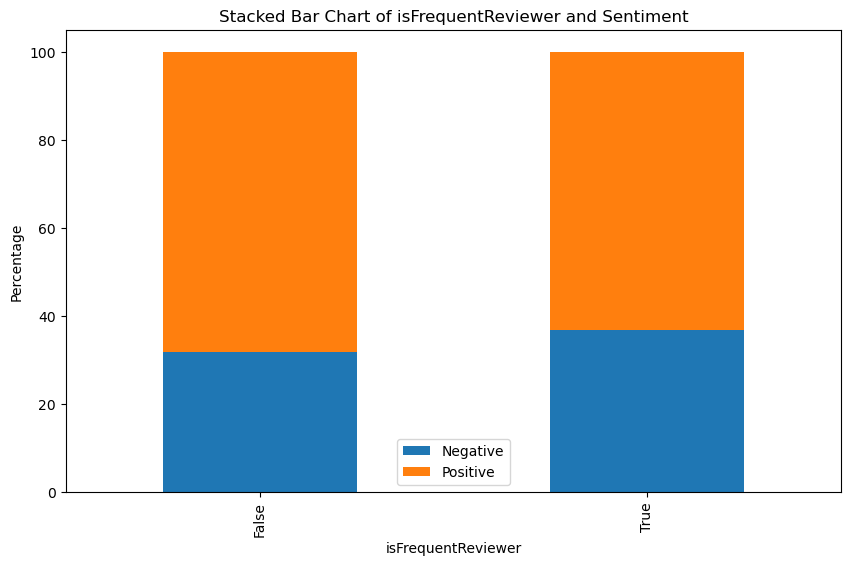

In [16]:
selected_columns = ["isFrequentReviewer", "sentiment"]

percentage_df = new_train.groupby(selected_columns).size().unstack()
percentage_df = percentage_df.apply(lambda row: row / row.sum() * 100, axis=1)

ax = percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel("isFrequentReviewer")
plt.ylabel("Percentage")
plt.title("Stacked Bar Chart of isFrequentReviewer and Sentiment")

handles, labels = ax.get_legend_handles_labels()
labels = ['Negative', 'Positive']
ax.legend(handles, labels)

plt.show()

### Findings:Distribution of Positives and Negatives were almost equal for True and False

## 2) Barplot Visualization:

POSITIVE    86905
NEGATIVE    43301
Name: sentiment, dtype: int64


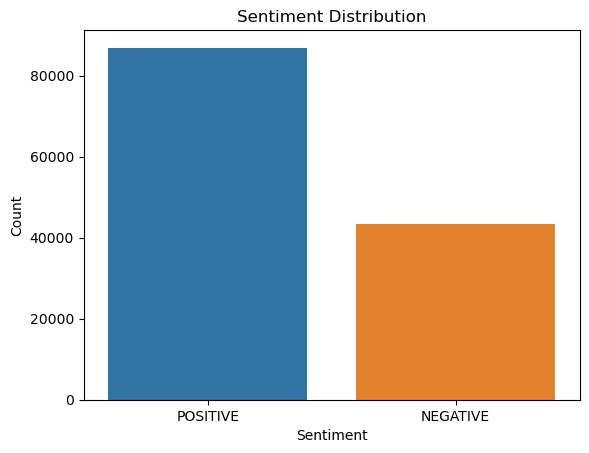

In [17]:
sentiment_counts = new_train['sentiment'].value_counts()
print(sentiment_counts)
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

plt.show()

### Findings: Positive sentiments are more than negatives

## 3) Heatmap Visualization of missing values:

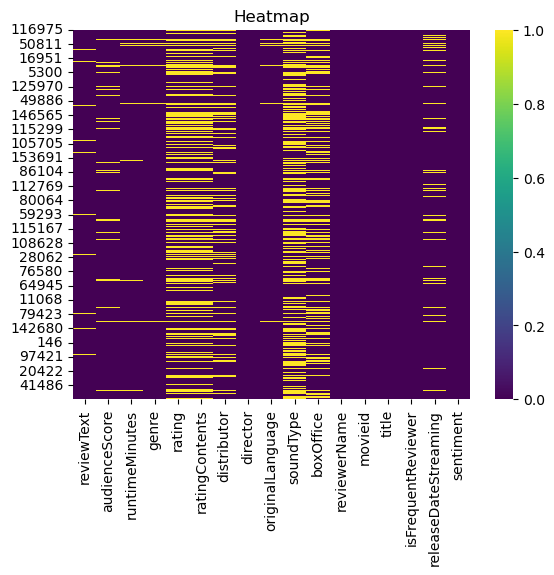

In [18]:
sns.heatmap(new_train.isnull(), cmap='viridis')

plt.title('Heatmap')

plt.show()

### Findings: It shows that only many columns has missing values

## Distribution of Audience Score by Sentiment using Boxplot

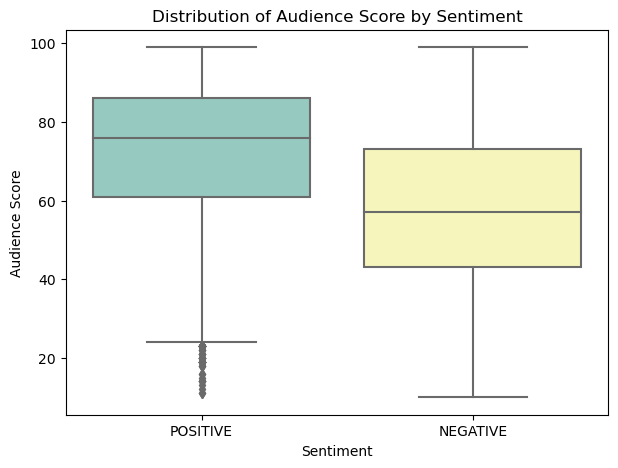

In [19]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='sentiment', y='audienceScore', data=new_train.dropna(), palette='Set3')
plt.title('Distribution of Audience Score by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Audience Score')
plt.show()

### Findings: If the Audience Score falls below 40 or rises above 72, the sentiment is categorized as 'POSITIVE'

# Data Preprocessing 

In [20]:
# Creating a SimpleImputer object for 'audienceScore' /outliers will not effect
imp1 = SimpleImputer(strategy='median', missing_values=np.nan)

# Impute missing values for 'audienceScore' column in new_train and new_test
new_train['audienceScore'] = imp1.fit_transform(new_train[['audienceScore']])
new_test['audienceScore'] = imp1.transform(new_test[['audienceScore']])
test_final['audienceScore'] = imp1.transform(test_final[['audienceScore']])


/tmp/ipykernel_20/1134994539.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_final['audienceScore'] = imp1.transform(test_final[['audienceScore']])


In [21]:
# Creating a SimpleImputer object for 'runtimeMinutes'
imp2 = SimpleImputer(strategy = 'mean' , missing_values= np.nan)
new_train['runtimeMinutes'] = imp2.fit_transform(new_train[['runtimeMinutes']])
new_test['runtimeMinutes'] = imp2.transform(new_test[['runtimeMinutes']])
test_final['runtimeMinutes'] = imp2.transform(test_final[['runtimeMinutes']])

/tmp/ipykernel_20/4265997976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_final['runtimeMinutes'] = imp2.transform(test_final[['runtimeMinutes']])


In [22]:
# Create a StandardScaler instance
scler = StandardScaler()

# Columns to scale
columns_to_scale = ['audienceScore', 'runtimeMinutes']

# Scale selected columns in new_train
new_train.loc[:, columns_to_scale] = scler.fit_transform(new_train[columns_to_scale].values)

# Scale selected columns in new_test using the mean and variance from new_train
new_test.loc[:, columns_to_scale] = scler.transform(new_test[columns_to_scale].values)

test_final.loc[:, columns_to_scale] = scler.transform(test_final[columns_to_scale].values)


/tmp/ipykernel_20/1765282954.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_final.loc[:, columns_to_scale] = scler.transform(test_final[columns_to_scale].values)


In [23]:
def preprocess_box_office(column):
    column = column.astype(str) 
    column = column.str.replace('$', '')
    column = column.str.replace('K', '000')
    column = column.str.replace('M', '000000')
    
    column = column.astype(float)
    median_value = column.median()
    column = column.fillna(value=median_value)
    return column

new_train['boxOffice'] = preprocess_box_office(new_train['boxOffice'])
new_test['boxOffice'] = preprocess_box_office(new_test['boxOffice'])
test_final['boxOffice'] = preprocess_box_office(test_final['boxOffice'])


/tmp/ipykernel_20/661157807.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  column = column.str.replace('$', '')
/tmp/ipykernel_20/661157807.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  column = column.str.replace('$', '')
/tmp/ipykernel_20/661157807.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  column = column.str.replace('$', '')
/tmp/ipykernel_20/661157807.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

## Used feature extraction on releaseDateStreaming

In [24]:
def extract_date_features(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name])
    df['day'] = df[column_name].dt.day
    df['month'] = df[column_name].dt.month
    df['year'] = df[column_name].dt.year

# Apply the function to both new_train and new_test DataFrames
extract_date_features(new_train, 'releaseDateStreaming')
extract_date_features(new_test, 'releaseDateStreaming')
extract_date_features(test_final, 'releaseDateStreaming')

date_features = ['day', 'month', 'year']

for feature in date_features:
    new_train[feature] = imp1.fit_transform(new_train[[feature]])
    new_test[feature] = imp1.transform(new_test[[feature]])
    test_final[feature] = imp1.transform(test_final[[feature]])
    

/tmp/ipykernel_20/2878074779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = pd.to_datetime(df[column_name])


In [25]:
print("Missing values before imputation in new_train dataset")
print(new_train.isna().sum())

print("Missing values before imputation in new_test dataset")
print(new_test.isna().sum())

print("Missing values before imputation in test_final dataset")
print(test_final.isna().sum())

text_columns = ['reviewText', 'genre','rating', 'ratingContents','distributor' ,'director', 'originalLanguage', 'soundType','reviewerName','movieid','title','isFrequentReviewer']
for column in text_columns:
    new_train[column] = new_train[column].fillna(value='')
    new_test[column] = new_test[column].fillna(value='')
    test_final[column] = test_final[column].fillna(value='')

print("Missing values after imputation in new_train dataset")
print(new_train.isna().sum())

print("Missing values after imputation in new_test dataset")
print(new_test.isna().sum())

print("Missing values after imputation in test_final dataset")
print(test_final.isna().sum())

Missing values before imputation in new_train dataset
reviewText               5228
audienceScore               0
runtimeMinutes              0
genre                    1964
rating                  51013
ratingContents          51013
distributor             32570
director                    0
originalLanguage         2648
soundType               68262
boxOffice                   0
reviewerName                0
movieid                     0
title                       0
isFrequentReviewer          0
releaseDateStreaming    12916
sentiment                   0
day                         0
month                       0
year                        0
dtype: int64
Missing values before imputation in new_test dataset
reviewText               1219
audienceScore               0
runtimeMinutes              0
genre                     474
rating                  12711
ratingContents          12711
distributor              8093
director                    0
originalLanguage          642
soundType 

# Text preprocessing with TF-IDF :

In [26]:
# Combine selected columns into a single text column
text_columns = ['reviewText', 'genre', 'ratingContents', 'director', 'originalLanguage', 'soundType',
                'reviewerName', 'movieid', 'title', 'isFrequentReviewer']
new_train['combined_text'] = new_train[text_columns].astype(str).apply(' '.join, axis=1)
new_test['combined_text'] = new_test[text_columns].astype(str).apply(' '.join, axis=1)
test_final['combined_text'] = test_final[text_columns].astype(str).apply(' '.join, axis=1)

# Initialize and fit the TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))
train_vector = vectorizer.fit_transform(new_train['combined_text'])
test_vector = vectorizer.transform(new_test['combined_text'])
vector_final = vectorizer.transform(test_final['combined_text'])


### Dropping the already processed columns.

In [27]:
# Drop unnecessary columns
columns_to_drop = text_columns + ['rating', 'distributor', 'boxOffice', 'releaseDateStreaming',
                                  'day', 'month', 'year']
new_train.drop(columns=columns_to_drop + ['combined_text','sentiment'], inplace=True)
new_test.drop(columns=columns_to_drop + ['combined_text','sentiment'], inplace=True)
test_final.drop(columns=columns_to_drop + ['combined_text'], inplace=True)

 ### Horizontally stack a TF-IDF sparse matrix with a sparse matrix derived from new_train or new_test.

In [28]:
from scipy.sparse import hstack,csr_matrix 
X = hstack([train_vector, csr_matrix(new_train)])
X_test = hstack([test_vector, csr_matrix(new_test)])
X_test_final = hstack([vector_final, csr_matrix(test_final)])

# Model Conclusion:
Best Score is 0.82762

1) LinearSVC is best model so far, with hyperparameters

2) 2nd best model Logistic regression with Hyperparameter Tunning

3) 3rd  Best Model is Ridge Classifier


# Model:0 Baseline Model

In [29]:
"""
model = DummyClassifier(strategy = 'most_frequent')
model.fit(X,y_tr)
model.score(X,y_tr)
"""

"\nmodel = DummyClassifier(strategy = 'most_frequent')\nmodel.fit(X,y_tr)\nmodel.score(X,y_tr)\n"

Dummy model score: 0.6682261037479154

# Model:1 Logistic Regression

Accuracy Score 0.8075387072990907

In [30]:

"""from sklearn.linear_model import LogisticRegression

lg=LogisticRegression()
lg.fit(X,y_tr)

ypred=lg.predict(X_test)

print('Accuracy Score',accuracy_score(y_t,ypred))

print('Classification_report')
print(classification_report(y_t,ypred))
print('Confusion Matrix')
print(confusion_matrix(y_t, ypred))

print('F1_Score',f1_score(ypred, y_t,pos_label='POSITIVE'))"""

"from sklearn.linear_model import LogisticRegression\n\nlg=LogisticRegression()\nlg.fit(X,y_tr)\n\nypred=lg.predict(X_test)\n\nprint('Accuracy Score',accuracy_score(y_t,ypred))\n\nprint('Classification_report')\nprint(classification_report(y_t,ypred))\nprint('Confusion Matrix')\nprint(confusion_matrix(y_t, ypred))\n\nprint('F1_Score',f1_score(ypred, y_t,pos_label='POSITIVE'))"

Accuracy Score 0.8075387072990907
Classification_report
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.59      0.67     10696
    POSITIVE       0.82      0.91      0.86     21856

    accuracy                           0.81     32552
   macro avg       0.79      0.75      0.77     32552
weighted avg       0.80      0.81      0.80     32552

Confusion Matrix
[[ 6330  4366]
 [ 1899 19957]]
F1_Score 0.8643322722449598

# Hyper Parameter Tuning for Logistic Regression

In [31]:
"""pipe = Pipeline([
    ('model', LogisticRegression())
])

param_dist = {
    'model__C': uniform(0.1, 1.0),
    'model__max_iter': [100, 200, 500],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=10,scoring='f1_micro', cv=2, n_jobs=-1, verbose=1,random_state=42)
random_search.fit(X, y_tr)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

"""

"pipe = Pipeline([\n    ('model', LogisticRegression())\n])\n\nparam_dist = {\n    'model__C': uniform(0.1, 1.0),\n    'model__max_iter': [100, 200, 500],\n    'model__penalty': ['l1', 'l2'],\n    'model__solver': ['liblinear', 'saga']\n}\n\nrandom_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=10,scoring='f1_micro', cv=2, n_jobs=-1, verbose=1,random_state=42)\nrandom_search.fit(X, y_tr)\n\nbest_params = random_search.best_params_\nbest_model = random_search.best_estimator_\n\n"

In [32]:
"""print('Logistic Regression HPT',best_params)
print('Best Model : Logistic Regression',best_model)"""

"print('Logistic Regression HPT',best_params)\nprint('Best Model : Logistic Regression',best_model)"

Logistic Regression HPT {'model__C': 0.8851759613930136, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best Model : Logistic Regression Pipeline(steps=[('model',
                 LogisticRegression(C=0.8851759613930136, max_iter=500,
                                    solver='liblinear'))])

# Training model after HPT

In [33]:
"""pipe = Pipeline([
#     ('model', LogisticRegression(C =  0.9555898857944699, max_iter= 200,penalty='l2',solver='saga'))
    ('model',LogisticRegression(C=0.8851759613930136, max_iter=500,solver='liblinear'))
])

pipe.fit(X, y_tr)

y_pred = pipe.predict(X_test)

accuracy = accuracy_score(y_t, y_pred)
print("Accuracy:", accuracy)

pred = pipe.predict(X_test)
print('Classification_report')
print(classification_report(y_t,pred))
print('Confusion Matrix')
print(confusion_matrix(y_t, pred))

print('F1_Score',f1_score(pred, y_t,pos_label='POSITIVE'))"""

'pipe = Pipeline([\n#     (\'model\', LogisticRegression(C =  0.9555898857944699, max_iter= 200,penalty=\'l2\',solver=\'saga\'))\n    (\'model\',LogisticRegression(C=0.8851759613930136, max_iter=500,solver=\'liblinear\'))\n])\n\npipe.fit(X, y_tr)\n\ny_pred = pipe.predict(X_test)\n\naccuracy = accuracy_score(y_t, y_pred)\nprint("Accuracy:", accuracy)\n\npred = pipe.predict(X_test)\nprint(\'Classification_report\')\nprint(classification_report(y_t,pred))\nprint(\'Confusion Matrix\')\nprint(confusion_matrix(y_t, pred))\n\nprint(\'F1_Score\',f1_score(pred, y_t,pos_label=\'POSITIVE\'))'

Accuracy: 0.8086446301302531
Classification_report
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.59      0.67     10696
    POSITIVE       0.82      0.91      0.87     21856

    accuracy                           0.81     32552
   macro avg       0.80      0.75      0.77     32552
weighted avg       0.80      0.81      0.80     32552

Confusion Matrix
[[ 6358  4338]
 [ 1891 19965]]
F1_Score 0.8650534023700688

# Model:2 LinearSVC


In [34]:
"""from sklearn.svm import LinearSVC

model = LinearSVC(random_state=42)
model.fit(X, y_tr)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_t, y_pred)
print("Accuracy:", accuracy)

print('Classification_report')
print(classification_report(y_t, y_pred))


print('F1_Score',f1_score(y_t,y_pred,pos_label = "POSITIVE"))

print('Confusion Matrix')
print(confusion_matrix(y_t, y_pred))"""

'from sklearn.svm import LinearSVC\n\nmodel = LinearSVC(random_state=42)\nmodel.fit(X, y_tr)\ny_pred = model.predict(X_test)\n\naccuracy = accuracy_score(y_t, y_pred)\nprint("Accuracy:", accuracy)\n\nprint(\'Classification_report\')\nprint(classification_report(y_t, y_pred))\n\n\nprint(\'F1_Score\',f1_score(y_t,y_pred,pos_label = "POSITIVE"))\n\nprint(\'Confusion Matrix\')\nprint(confusion_matrix(y_t, y_pred))'

Accuracy: 0.8236974686655197
Classification_report
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.67      0.72     10696
    POSITIVE       0.85      0.90      0.87     21856

    accuracy                           0.82     32552
   macro avg       0.81      0.79      0.79     32552
weighted avg       0.82      0.82      0.82     32552

F1_Score 0.872321964893546
Confusion Matrix
[[ 7208  3488]
 [ 2251 19605]]

# Hyper Parameter Tuning for Linear SVC

In [35]:
"""param_grid = {
    'C': [0.5, 1, 1.5, 2 , 5, 10],
    'max_iter': [100, 200, 400, 800, 1000]
}
grid_search = GridSearchCV(linear_svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1,random_state=42)

grid_search.fit(x_tr, y_tr)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
"""

"param_grid = {\n    'C': [0.5, 1, 1.5, 2 , 5, 10],\n    'max_iter': [100, 200, 400, 800, 1000]\n}\ngrid_search = GridSearchCV(linear_svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1,random_state=42)\n\ngrid_search.fit(x_tr, y_tr)\nbest_params = grid_search.best_params_\nbest_model = grid_search.best_estimator_\n"

In [36]:
"""print('LinearSVC HPT',best_params)
print('Best Model : LinearSVC',best_model)"""

"print('LinearSVC HPT',best_params)\nprint('Best Model : LinearSVC',best_model)"

### Best parameters: {'C': 1, 'max_iter': 400}


# Training model after HPT: 

In [37]:
model2 = LinearSVC(C=1,max_iter=400,random_state=42)
model2.fit(X, y_tr)
y_pred = model2.predict(X_test)

accuracy = accuracy_score(y_t, y_pred)
print("Accuracy:", accuracy)

print('Classification_report')
print(classification_report(y_t, y_pred))


print('F1_Score',f1_score(y_t,y_pred,pos_label = "POSITIVE"))

print('Confusion Matrix')
print(confusion_matrix(y_t, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.8237281887441632
Classification_report
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.67      0.72     10696
    POSITIVE       0.85      0.90      0.87     21856

    accuracy                           0.82     32552
   macro avg       0.81      0.79      0.79     32552
weighted avg       0.82      0.82      0.82     32552

F1_Score 0.8723413722523805
Confusion Matrix
[[ 7209  3487]
 [ 2251 19605]]


Accuracy: 0.8236974686655197
Classification_report
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.67      0.72     10696
    POSITIVE       0.85      0.90      0.87     21856

    accuracy                           0.82     32552
   macro avg       0.81      0.79      0.79     32552
weighted avg       0.82      0.82      0.82     32552

F1_Score 0.8723413722523805
Confusion Matrix
[[ 7209  3487]
 [ 2251 19605]]


# Model:3 Ridge Classifier

In [38]:
""" 
param_distributions = {
    'alpha': uniform(loc=0, scale=10),  
    'solver': ['auto', 'svd', 'sag', 'saga']
}
model4 = RidgeClassifier()
random_search = RandomizedSearchCV(estimator=model4, 
                                    param_distributions=param_distributions,
                                    cv=5, 
                                    n_iter=10)

random_search.fit(x_tr, y_tr)
best_params = random_search.best_params_
 
#best_params: {'alpha': 3.096149524540197, 'solver': 'auto'}


best_model = RidgeClassifier(alpha = 3.096149524540197, solver = 'auto')
best_model.fit(X_tr, y_tr)
best_model.score(X_tr, y_tr)


"""

" \nparam_distributions = {\n    'alpha': uniform(loc=0, scale=10),  \n    'solver': ['auto', 'svd', 'sag', 'saga']\n}\nmodel4 = RidgeClassifier()\nrandom_search = RandomizedSearchCV(estimator=model4, \n                                    param_distributions=param_distributions,\n                                    cv=5, \n                                    n_iter=10)\n\nrandom_search.fit(x_tr, y_tr)\nbest_params = random_search.best_params_\n \n#best_params: {'alpha': 3.096149524540197, 'solver': 'auto'}\n\n\nbest_model = RidgeClassifier(alpha = 3.096149524540197, solver = 'auto')\nbest_model.fit(X_tr, y_tr)\nbest_model.score(X_tr, y_tr)\n\n\n"

In [39]:
""" 
pred = best_model.predict(x_t)

print(classification_report(y_t,pred))
print(confusion_matrix(y_t, pred))
print(f1_score(pred, y_t,pos_label='POSITIVE'))
"""

" \npred = best_model.predict(x_t)\n\nprint(classification_report(y_t,pred))\nprint(confusion_matrix(y_t, pred))\nprint(f1_score(pred, y_t,pos_label='POSITIVE'))\n"

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.47      0.59     16198
    POSITIVE       0.78      0.94      0.85     32630

    accuracy                           0.78     48828
     macro avg       0.79      0.70      0.72     48828
    weighted avg       0.79      0.78      0.77     48828
    
    Confusion Matrix

    [[ 7556  8642]
    [ 1858 30772]]
    
    F1 score:  0.8542557326078507

# Model:4 Decision Tree

In [40]:
"""from sklearn.tree import DecisionTreeClassifier

model4 = DecisionTreeClassifier()
model4.fit(x_tr, y_tr)

pred=model4.predict(x_tr)
print('Accuracy Score: ',accuracy_score(y_tr,pred))
print('Classification Report')
print(classification_report(y_tr,pred))
print('Confusion Matrix',confusion_matrix(y_tr,pred))
"""

"from sklearn.tree import DecisionTreeClassifier\n\nmodel4 = DecisionTreeClassifier()\nmodel4.fit(x_tr, y_tr)\n\npred=model4.predict(x_tr)\nprint('Accuracy Score: ',accuracy_score(y_tr,pred))\nprint('Classification Report')\nprint(classification_report(y_tr,pred))\nprint('Confusion Matrix',confusion_matrix(y_tr,pred))\n"

# Submission File

In [41]:
pred = model2.predict(X_test_final)

In [42]:
submission = pd.DataFrame(columns = ['id', 'sentiment'])
submission['id'] = [i for i in range(len(pred))]
submission['sentiment'] = pred
submission.to_csv('submission.csv', index = False )

In [43]:
submission["sentiment"].value_counts()

POSITIVE    39140
NEGATIVE    16175
Name: sentiment, dtype: int64